In [1]:
import itertools

import numpy as np
import scipy.stats
import scipy.interpolate

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.transforms

%matplotlib inline

import fklab.geometry.shapes

In [2]:
def plot_track(track, axes=None, **kwargs):
    """Convenience track plotting function
    
    Parameters
    ----------
    track : fklab.geometry.shapes.path
    axes : Axes
    **kwargs :
        Extra keyword arguments for `plot` function
    
    Returns
    -------
    Axes
    
    """
    
    if axes is None:
        axes = plt.gca()
    
    if isinstance(track, fklab.geometry.shapes.graph):
        xy = [x.samplepath() for x in track._polylines]
        [axes.plot(x[:,0], x[:,1], **kwargs) for x in xy]
    else:
        xy = curved_track.samplepath()
        axes.plot(xy[:,0], xy[:,1], **kwargs)
    
    return axes

In [3]:
def track2map(track, resolution=1., expand=1.4):
    """Construct an map of distances along/to a track
    
    Parameters
    ----------
    track : fklab.geometry.shapes.path
    resolution : scalar
        size of each point in the map
    expand : scalar
        Factor by which the scale the bounding box of the track
    
    Returns
    -------
    L, D : 2d array
        Maps of linearized position along the track (L) and distance to
        the track (D) for every point in the map.
    x, y : 1d array
        Coordinates for each point in the map.
    
    """
    
    nx, ny = np.ceil(track.boundingbox.size[[0,-1]] * 1.4 / resolution)
    cx, cy = track.boundingbox.center
    
    vx = (np.arange(nx)-(nx-1)/2)*resolution+cx
    vy = (np.arange(ny)-(ny-1)/2)*resolution+cy
    mx, my = np.meshgrid(vx, vy)
    
    L,D,_,_ = track.point2path(np.column_stack([mx.ravel(), my.ravel()]))
    L = np.reshape(L, mx.shape)
    D = np.reshape(D, mx.shape)
    
    return L,D, (vx, vy)

In [4]:
def enhanced_scatter(*args, rotations=None, alphas=None, axes=None, **kwargs):
    """Scatter plot that supports varying rotation and alpha for each marker.
    
    Parameters
    ----------
    *args, **kwargs : 
        Arguments for the matplotlib `scatter` function
    rotations : scalar or 1d array-like
        Marker rotations.
    alphas : scalar or 1d array-like
        Marker alpha values
    
    Returns
    -------
    PathCollection
    
    """
    
    if axes is None:
        axes = plt.gca()
    
    h = axes.scatter(*args, **kwargs)
    
    if not rotations is None:
        rotations = np.ravel(rotations)
        
        paths = h.get_paths()
        
        if len(paths)==1:
            paths = [p.transformed(matplotlib.transforms.Affine2D().rotate(phi)) 
                     for p, phi in zip(itertools.cycle(paths),rotations)]
        else:
            paths = [p.transformed(matplotlib.transforms.Affine2D().rotate(phi)) 
                     for p, phi in zip(paths,itertools.cycle(rotations))]
        
        h.set_paths(paths)
        
    if not alphas is None:
        alphas = np.ravel(alphas)
        
        fc = h.get_facecolors()
        
        if len(fc)>0:
            alphas_ = alphas
            if len(fc)==1:
                fc = np.broadcast_to(fc,(len(alphas),4)).copy()
            elif len(alphas)==1:
                alphas_ = np.broadcast_to(alphas,len(fc))

            fc[:,3] *= alphas_

            h.set_facecolors(fc)
        
        ec = h.get_edgecolors()
        
        if len(ec)>0:
            alphas_ = alphas
            if len(ec)==1:
                ec = np.broadcast_to(ec,(len(alphas),4)).copy()
            elif len(alphas)==1:
                alphas_ = np.broadcast_to(alphas,len(ec))

            ec[:,3] *= alphas_

            h.set_facecolors(ec)

    return h

In [136]:
from data_analysis import loading

In [6]:
loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0')
loading.load_cluster()
ls_data = loading.cluster_data
loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/Events.nev',)

In [7]:
Fs = 3000
time_shift = -6.439110058088235
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift

In [8]:
#loading spiking data
project_root = '/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [9]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
#print(data[data['KSLabel'] == 'good'])
# data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']

In [10]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']

In [11]:
import pandas as pd
channel_cluster = []
channel_label = []

for cluster_index, cluster_id in enumerate(id_s):
    channel_cluster.append(str(cluster_id)) 
    channel_label.append(str(channel[cluster_index]))

    
cluster_channel = pd.DataFrame({'cluster':channel_cluster,'channel':channel_label})    

# print(cluster_channel)
cluster_channel.to_csv('Cluster_channel_LS_K_5_140320.tsv', sep = '\t')

In [12]:
epoch = loading.position_yaml['source']['epoch']
epoch
open_field_epoch = [4231, 6108]
Y_maze_epoch = [2517, 4185]


In [13]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['AT']['shapes']['AT']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
ymaze = graph(**Y_maze_data)


In [14]:
position_at = loading.position[np.logical_and(corrected_time > Y_maze_epoch[0],
                                      corrected_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.27

position_of = loading.position[np.logical_and(corrected_time > open_field_epoch[0],
                                      corrected_time < open_field_epoch[1]), :]
position_of_cm = position_of * 0.27

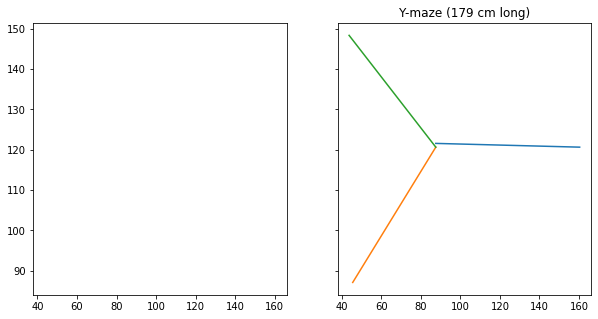

In [15]:
fig,axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

plot_track(ymaze, axes=axes[1])
axes[1].set(title='Y-maze ({:.0f} cm long)'.format(ymaze.pathlength));

In [123]:
# let's bin the track
bins, nbins, binsize = ymaze.bin(binsize=5, separate=True)

# compute bin centers
bincenters = (bins[:-1] + bins[1:])/2.

data_ymaze = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)


data_ymaze2 = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)

data_ymaze3 = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)
data_ymaze4 = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)

data_ymaze5 = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)

data_ymaze6 = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)


data = dict(
    vel_bins = [10, 12, 14, 16, 18, 20,
               22, 24, 26, 28, 30, 32,
               34,36,38,40,42,44,46,48,
               50,52,54,56,58,60]
)
v_bins =  [10, 12, 14, 16, 18, 20,
               22, 24, 26, 28, 30, 32,
               34,36,38,40,42,44,46,48,
               50,52,54,56,58,60]

In [18]:
import pandas as pd
cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
ks_spike_times = loading.ks_spike_times[:,0]
spike_time_rangeat = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift
t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
linear_posat = ymaze.point2path(position_at_cm)[0]



In [137]:
for cl in cluster_channel['cluster']:
    spike_xat = ks_spike_times[loading.get_spike_seq(spike_time_rangeat, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xat

In [166]:
from fklab.ratemap.histogram_based_rate_map import general_tuning
rate, eventcount_density, occupancy_density,binedges = general_tuning(spike_t[177], stimdata=linear_posat, t= t_at, bins=[data_ymaze['bins']])
rate2, eventcount_density, occupancy_density,binedges = general_tuning(spike_t[198], stimdata=linear_posat, t= t_at, bins=[data_ymaze['bins']])
rate3, eventcount_density, occupancy_density,binedges = general_tuning(spike_t[193], stimdata=linear_posat, t= t_at, bins=[data_ymaze['bins']])
rate4, eventcount_density, occupancy_density,binedges = general_tuning(spike_t[26], stimdata=linear_posat, t= t_at, bins=[data_ymaze['bins']])

data_ymaze['rate'] = rate[0]
data_ymaze2['rate'] = rate2[0]  
data_ymaze3['rate'] = rate3[0]
data_ymaze4['rate'] = rate4[0]


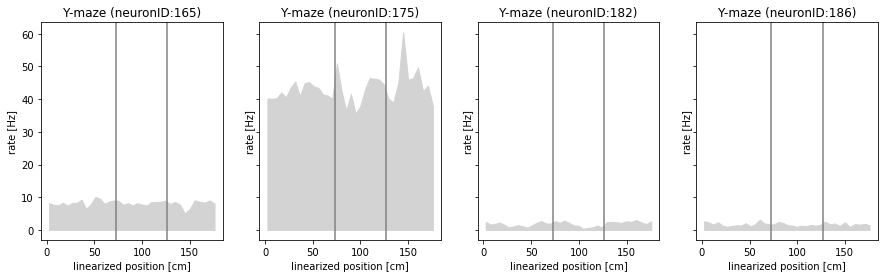

In [167]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,4))

# areaplot

axes[0].fill_between(data_ymaze['bincenters'],
                     data_ymaze['rate'],
                     color='lightgray')

axes[0].set(title="Y-maze (neuronID:165)", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[0].axvline(edgelengths[0], color='gray')
axes[0].axvline(edgelengths[1], color='gray');

axes[1].fill_between(data_ymaze['bincenters'],
                     data_ymaze2['rate'],
                     color='lightgray')

axes[1].set(title="Y-maze (neuronID:175)", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[1].axvline(edgelengths[0], color='gray')
axes[1].axvline(edgelengths[1], color='gray');


axes[2].fill_between(data_ymaze['bincenters'],
                     data_ymaze3['rate'],
                     color='lightgray')

axes[2].set(title="Y-maze (neuronID:182)", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[2].axvline(edgelengths[0], color='gray')
axes[2].axvline(edgelengths[1], color='gray');

axes[3].fill_between(data_ymaze['bincenters'],
                     data_ymaze4['rate'],
                     color='lightgray')

axes[3].set(title="Y-maze (neuronID:186)", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[3].axvline(edgelengths[0], color='gray')
axes[3].axvline(edgelengths[1], color='gray');


plt.savefig("Rateareaplot1D_165_175_182_186_140320.png")

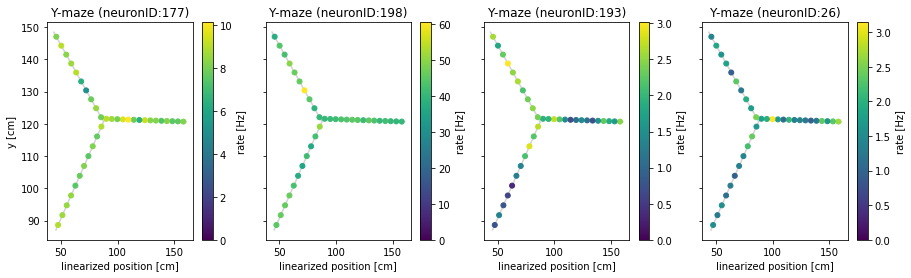

In [168]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,4))

colormap = 'viridis'
markersize = 25

for ax, data in zip(axes, [data_ymaze, data_ymaze2, data_ymaze3, data_ymaze4]):
    
    # plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    
    h = ax.scatter(bin_xy[:,0], bin_xy[:,1], c=data['rate'], s=markersize,
                   marker='o', vmin=0, zorder=3, cmap=colormap)
    
    # create color bar
    plt.colorbar(h, ax=ax, label='rate [Hz]')
    
axes[0].set(ylabel='y [cm]');

axes[0].set(title="Y-maze (neuronID:177)", xlabel='linearized position [cm]', ylabel='y [cm]')
axes[1].set(title="Y-maze (neuronID:198)", xlabel='linearized position [cm]')
axes[2].set(title="Y-maze (neuronID:193)", xlabel='linearized position [cm]')
axes[3].set(title="Y-maze (neuronID:26)", xlabel='linearized position [cm]');


plt.savefig("Rate1D_177_198_193_26_140320.png")
# [ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_ymaze, data_ymaze2])];
# plt.savefig(rate1Dn2_4_)

In [150]:
450.3256735540773 * 0.27

121.58793185960087

In [73]:
print(161.754975 * 0.27)
print( 118.9 * 0.27)
print(81.770175 * 0.27)
print(119.620125 * 0.27)
print(48.5622 * 0.27)
print(92.482425 * 0.27)
print(47.490975 * 0.27)
print( 147.11489999999998 * 0.27)
print(153.59872032747646 * 0.27)
print(48.56219999999999 * 0.27)
print(93.55364999999999 * 0.27)
print(21.094641953141792 * 0.27)
print(0.013717000095719965 * 0.27)

43.673843250000004
32.103
22.07794725
32.29743375
13.111794
24.970254750000002
12.82256325
39.721022999999995
41.47165448841864
13.111793999999998
25.2594855
5.695553327348284
0.003703590025844391
